In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import largestinteriorrectangle as lir

In [2]:
def generate_convex_polygon(image_size=64, num_points=9):
    # 生成随机点
    points = np.random.randint(0, image_size, (num_points, 2))
    
    # 计算凸包
    hull = ConvexHull(points)
    
    # 返回凸包的顶点
    return points[hull.vertices]

In [3]:
def generate_random_polygon_image(image_size=64, num_points=6):
    # 生成随机的多边形顶点
    points = generate_convex_polygon(image_size, num_points)
    # 创建空白图像
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    # 画出多边形
    cv2.fillPoly(image, [points], 255)
    # 返回多边形图像和顶点（在真实问题中，你可能希望返回内接矩形的标签）
    return image, points

In [75]:
# # 展示生成的多边形
# def display_polygon_image():
#     # 生成多边形
#     num_points = np.random.randint(5, 21)
#     print(num_points)
#     image, points = generate_random_polygon_image(image_size=64, num_points=9)
#     rectangle =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
#     rect = np.array([(rectangle[0],rectangle[1]), 
#                      (rectangle[0],rectangle[1]+rectangle[3]-1), 
#                      (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
#                      (rectangle[0]+rectangle[2]-1,rectangle[1])])
#     rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
#     # 显示图像
#     plt.figure(figsize=(5, 5))
#     print(image.shape)
#     plt.imshow(image, cmap='gray')  # 灰度图像
#     plt.plot(rect[:, 0], rect[:, 1], 'r--')
#     # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
#     plt.title('Random Polygon')
#     plt.show()

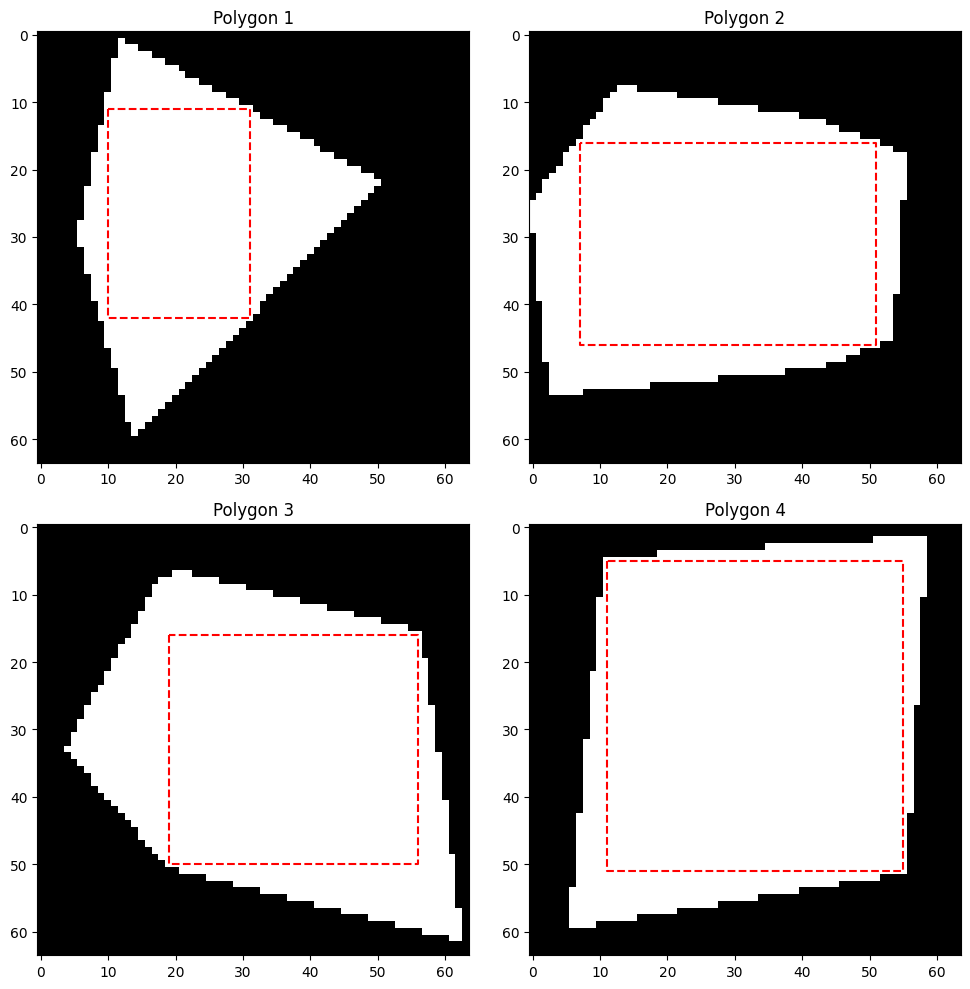

In [7]:
# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    point_range=[5,21]
    num_points = np.random.randint(point_range[0], point_range[1])
    image, _ = generate_random_polygon_image(image_size=64, num_points=num_points)
    # point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [8]:
# 生成训练数据 (多边形和最大内接矩形参数)
def generate_training_data(num_samples=1000, image_size=64, point_range=[5,21]) :
    data = []
    for _ in range(num_samples):
        num_points = np.random.randint(point_range[0], point_range[1])
        image, _ = generate_random_polygon_image(image_size=image_size, num_points=9)
        point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
        data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    return data

In [9]:
%%time
import os
import pickle

# 保存为二进制文件
file_path = "data.pkl"
train_data = None
if os.path.exists(file_path):
    print("从文件导入训练数据")
    with open(file_path, 'rb') as file:
        train_data = pickle.load(file)  # 这里应该传递文件对象，而不是文件路径
else:
    print("生成训练数据")
    train_data = generate_training_data(10000)
    with open(file_path, 'wb') as file:
        pickle.dump(train_data, file)

从文件导入训练数据
CPU times: total: 93.8 ms
Wall time: 72.3 ms


In [10]:
train_data[0:2], len(train_data)

([(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([33, 14, 22, 30], dtype=uint32)),
  (array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([11, 28, 37, 26], dtype=uint32))],
 10000)

In [11]:
# 展示生成的多边形
def display_polygon_image_x(image, rectangle):
    rect = np.array([(rectangle[0],rectangle[1]), 
                     (rectangle[0],rectangle[1]+rectangle[3]-1), 
                     (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
                     (rectangle[0]+rectangle[2]-1,rectangle[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
    # 显示图像
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')  # 灰度图像
    plt.plot(rect[:, 0], rect[:, 1], 'r--')
    # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
    plt.title('Random Polygon')
    plt.show()

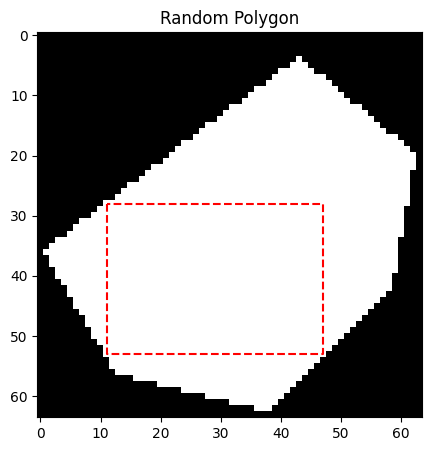

In [15]:
display_polygon_image_x(train_data[1][0].reshape(64,64),train_data[1][1])

In [16]:
dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\loki_\AppData\Local\Temp\ipykernel_1704\596144479.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))


In [17]:
# 简单的全连接神经网络
class RectNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(RectNet, self).__init__()
        # self.fc1 = nn.Linear(input_size, 128)
        # self.fc2 = nn.Linear(128, 64)
        # self.fc3 = nn.Linear(64, output_size)
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),       
            nn.LeakyReLU(0.02),
            nn.Dropout(0.5),      # Dropout 层
        
            # 10 filters to 10 filters
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          
            nn.LeakyReLU(0.02),    
            nn.Dropout(0.3),      # Dropout 层
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        return self.model(x)

In [18]:
len(train_data[0][0])

4096

In [19]:
model = RectNet(input_size=len(train_data[0][0]), output_size=4)

In [20]:
# 优化器 - Adam，学习率为0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器 - 每10个epoch降低学习率
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

In [21]:
# 训练模型
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()  # 训练模式
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()  # 更新权重
            
            running_loss += loss.item()
        
        # 学习率调度
        scheduler.step()
        
        # 打印每个epoch的平均损失
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [22]:
train(model, dataloader, criterion, optimizer, scheduler, num_epochs=100)

Epoch [1/100], Loss: 429.4013
Epoch [2/100], Loss: 68.8816
Epoch [3/100], Loss: 34.2347
Epoch [4/100], Loss: 32.2293
Epoch [5/100], Loss: 30.5687
Epoch [6/100], Loss: 29.7075
Epoch [7/100], Loss: 29.2085
Epoch [8/100], Loss: 28.6563
Epoch [9/100], Loss: 28.0728
Epoch [10/100], Loss: 27.5814
Epoch [11/100], Loss: 27.0493
Epoch [12/100], Loss: 26.8293
Epoch [13/100], Loss: 26.6464
Epoch [14/100], Loss: 26.4897
Epoch [15/100], Loss: 26.0306
Epoch [16/100], Loss: 26.3183
Epoch [17/100], Loss: 26.0000
Epoch [18/100], Loss: 25.8175
Epoch [19/100], Loss: 26.1060
Epoch [20/100], Loss: 25.6026
Epoch [21/100], Loss: 25.7370
Epoch [22/100], Loss: 25.5976
Epoch [23/100], Loss: 25.7760
Epoch [24/100], Loss: 25.8881
Epoch [25/100], Loss: 26.2680
Epoch [26/100], Loss: 25.7638
Epoch [27/100], Loss: 25.6075
Epoch [28/100], Loss: 25.6172
Epoch [29/100], Loss: 26.4018
Epoch [30/100], Loss: 25.7533
Epoch [31/100], Loss: 25.6727
Epoch [32/100], Loss: 25.8491
Epoch [33/100], Loss: 25.6798
Epoch [34/100], Lo

In [23]:
num_points = np.random.randint(point_range[0], point_range[1])
testimages, _ = generate_random_polygon_image(image_size=64, num_points=9)

*************************
point = [14.116491 22.629747 36.225746 27.738007]
real_point = [14 25 35 26]
loss = 2.5386970043182373
hand loss = [-0.11649132  2.37025261 -1.22574615 -1.73800659]
*************************
point = [12.826219 11.58799  38.158752 34.60637 ]
real_point = [13 11 37 38]
loss = 3.308842658996582
hand loss = [ 0.17378139 -0.58798981 -1.15875244  3.39363098]
*************************
point = [13.615317 30.802153 26.603582 17.487461]
real_point = [ 7 33 25 13]
loss = 17.825435638427734
hand loss = [-6.61531734  2.19784737 -1.60358238 -4.48746109]
*************************
point = [12.648227  5.824352 22.345413 30.469105]
real_point = [17  9 21 30]
loss = 7.763216972351074
hand loss = [ 4.35177326  3.17564821 -1.34541321 -0.46910477]


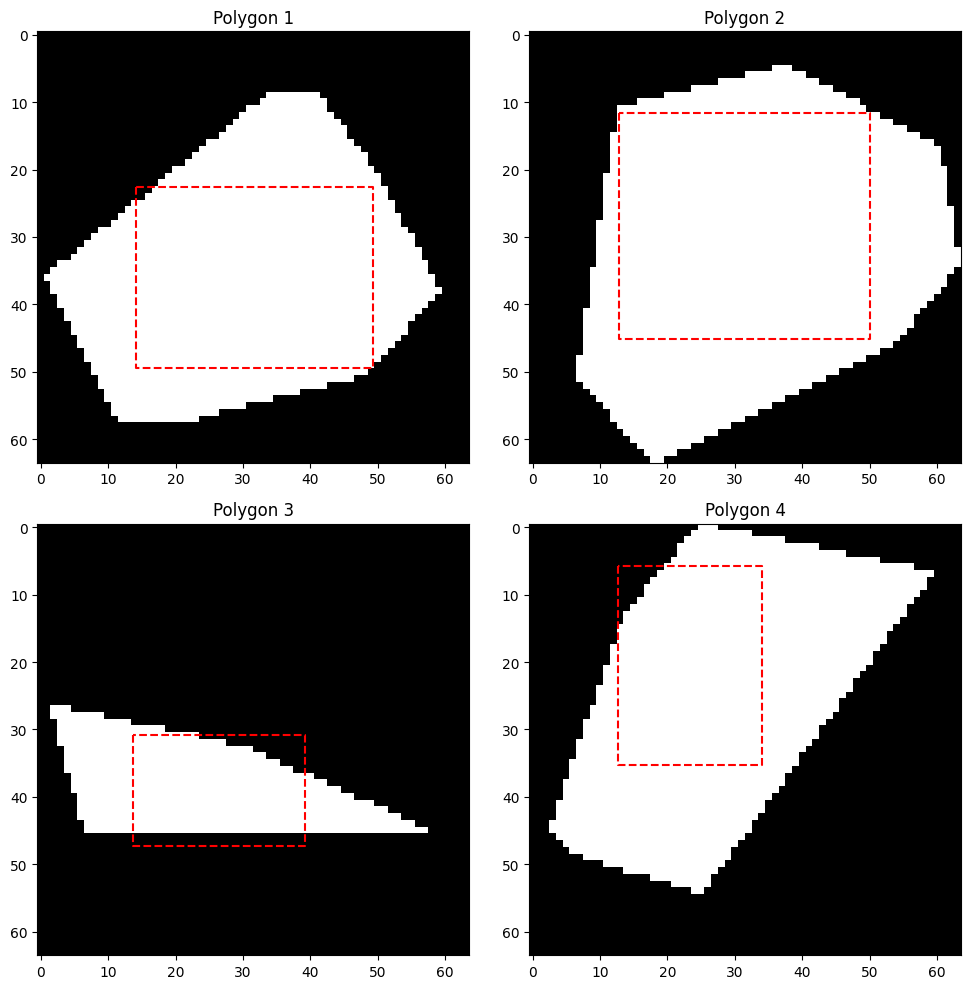

In [45]:
# 生成4个凸多边形
model.eval()

# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    num_points = np.random.randint(point_range[0], point_range[1])
    image, _ = generate_random_polygon_image(image_size=64, num_points=num_points)
    real_point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    # data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    with torch.no_grad():
        test_input = torch.tensor(image.flatten(), dtype=torch.float32).unsqueeze(0)
        # point = model(test_input).squeeze().numpy()
        output = model(test_input)
        # print(f"output = {output}  | output.squeeze = {output.squeeze()} ") 
        # print(f"type(output.squeeze())  = {output.squeeze().shape} ")
        # print(f"type(real_point)  = {real_point.shape} ")
        # break
        loss = criterion(output.squeeze(), torch.tensor(real_point, dtype=torch.float32))      
        point = output.squeeze().numpy()
        print("*"*25)
        print(f"point = {point}")
        print(f"real_point = {real_point}")
        print(f"loss = {loss}")
        # print(f"hand loss = {sum((real_point - point)**2)/4}")
        print(f"hand loss = {real_point - point}")
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()